In [34]:
import os
import sys
import fnmatch
import pandas as pd
from os.path import isfile, join
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
#import magcolloids as mgc
from matplotlib.patches import Rectangle

#sys.path.insert(0, '../icenumerics')

#import icenumerics as ice

sys.path.insert(0, '../Scripts')
from importlib import reload  
import From_Cairo_to_Shakti as lattices
reload(lattices)

mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "green", "purple", 
                                                    "orange", "royalblue", "limegreen", 
                                                    "blueviolet","darkorange", "tomato",
                                                    "red","black"])

# Vertex Count (theta)

In this script, I will generate the vertex count plot for each theta value. Then I will save the last frame information, to build the transfer of charge picture. 

In [2]:
data_directory = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-14.0"

In [3]:
#def count_vertices(vrt, exp = 'Exp', column = "type", column1 = "coordination", time = "frame"):
#    vrt_count = vrt.groupby([exp,time,column,column1]).count().iloc[:,0].to_frame("number")
#
#    vrt_count = vrt_count.reindex(pd.MultiIndex.from_product(
#        [vrt_count.index.get_level_values(exp).unique(),
#        vrt_count.index.get_level_values(time).unique(),
#        vrt_count.index.get_level_values(column).unique(),
#        vrt_count.index.get_level_values(column1).unique()]), fill_value = 0)

#    total_vrt = vrt_count.groupby([exp,time,column1]).sum()
#    array_coord = total_vrt.loc[vrt_count.index.get_level_values('frame')].number.values
#    array_coordT = np.tile(array_coord,int(len(vrt_count)/len(array_coord)))# 9 times of charges and 10 experiments 
#    vrt_count["fraction"] = vrt_count.number / array_coordT
        
#    return vrt_count

In [4]:
def count_vertices(vrt, exp = 'Exp', column = "type", column1 = "coordination", time = "frame"):
    vrt_count = vrt.groupby([exp,time,column,column1]).count().iloc[:,0].to_frame("number")

    vrt_count = vrt_count.reindex(pd.MultiIndex.from_product(
        [vrt_count.index.get_level_values(exp).unique(),
        vrt_count.index.get_level_values(time).unique(),
        vrt_count.index.get_level_values(column).unique(),
        vrt_count.index.get_level_values(column1).unique()]), fill_value = 0)

    total_vrt = vrt_count.groupby([exp,time,column1]).sum()
    array_coord = total_vrt.loc[vrt_count.index.get_level_values('frame')].number.values
    #array_coordT = np.tile(array_coord,9*10)# 9 times of charges and 10 experiments 
    print(len(vrt_count),len(array_coord))
    #array_coordT = np.tile(array_coord,round(int(len(vrt_count)/len(array_coord))))# 9 types of charges and 10 experiments 
    array_coordT = np.tile(array_coord[:2],int(len(vrt_count)/2))

    vrt_count["fraction"] = vrt_count.number / array_coordT
        
    return vrt_count

In [5]:
theta = np.linspace(np.pi/6, 5*np.pi/180, num= 15, endpoint=True, retstep=False, dtype=None, axis=0)
theta

array([0.52359878, 0.49243218, 0.46126559, 0.43009899, 0.3989324 ,
       0.36776581, 0.33659921, 0.30543262, 0.27426603, 0.24309943,
       0.21193284, 0.18076624, 0.14959965, 0.11843306, 0.08726646])

In [6]:
last_frame = []
for i in range(0,15):
    
    Lattices = []
    keys_Lattices = []
    for file in os.listdir(data_directory):
        if fnmatch.fnmatch(file, f"ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta{theta[i]}_exp*.dat"):
            print(file)
            Lattices.append(pd.read_csv(join(data_directory,file), sep = "\t", index_col = [0,1])) 
            keys_Lattices.append(theta[i])
    
    print(len(Lattices))
    #e = np.arange(0,10)
    e = np.arange(0,len(Lattices))
    Lattices_exp = pd.concat(Lattices, keys = e)
    print(len(Lattices_exp))

    Lattices_exp.index.names = ['Exp', 'frame', 'id']
    Lattices_exp

### Filter the vertices at the boundaries 

    First_frame = Lattices_exp.loc[0,0]

    d = 13 # Interparticle distance
    trap_sep_l = 10 # trap_sep parameter of the edge connecting 3 coordination and 4 coordination vertices
    s_l4 = d*np.sqrt(2)/2

    # <Generating lattice parameters depending on theta value>
    trap_sep_a, s_l3, a, l, plaquette_cte = lattices.lattice_parameters(theta[i], d, trap_sep_l, s_l4)

    x_min = plaquette_cte/2
    y_min = plaquette_cte

    width = plaquette_cte*16
    hight = plaquette_cte*16

    x_max = x_min+width
    y_max = y_min+hight

    #print(x_min,x_max,y_min,y_max)

    #fig =plt.figure(figsize = (15,15))
    #ax = fig.add_subplot(111)

    #plt.plot(First_frame.x, First_frame.y , 'o')
    #ax.add_patch(Rectangle((x_min, y_min),width, hight,fc ='none', ec ='g',lw = 5))

    Ca = Lattices_exp.loc[(Lattices_exp['x']<x_max) & (Lattices_exp['x']>x_min)]
    Lattices_exp = Ca.loc[(Ca['y']<y_max) & (Ca['y']>y_min)]

    ### Classify vertices

    Lattices_exp["type"] = np.NaN

    # 4-fold vertices classification

    Lattices_exp.loc[Lattices_exp.charge==-4, "type"] = "Q = -4"
    Lattices_exp.loc[Lattices_exp.charge==-2, "type"] = "Q = -2"
    Lattices_exp.loc[Lattices_exp.charge==+2, "type"] = "Q = +2"
    Lattices_exp.loc[Lattices_exp.charge==+4, "type"] = "Q = +4"

    zeroq = Lattices_exp.charge==0

    dipole_magnitude = np.sqrt(Lattices_exp[zeroq].dx**2+Lattices_exp[zeroq].dy**2)

    Lattices_exp.loc[zeroq & (dipole_magnitude<1), "type"] = "Q = 0"
    Lattices_exp.loc[zeroq & (dipole_magnitude>2) , "type"] = "Q = 0"

    # 3-fold vertices classification

    Lattices_exp.loc[Lattices_exp.charge==+1, "type"] = "Q = +1"
    Lattices_exp.loc[Lattices_exp.charge==-1, "type"] = "Q = -1"
    Lattices_exp.loc[Lattices_exp.charge==+3, "type"] = "Q = +3"
    Lattices_exp.loc[Lattices_exp.charge==-3, "type"] = "Q = -3"

    Lattices_exp =Lattices_exp.query('coordination == 4 or coordination == 3')

    count_m = count_vertices(Lattices_exp)

    v_counts_m = count_m.groupby(["frame","type","coordination"]).mean()
    v_counts_m["err"] = count_m['fraction'].groupby(["frame","type","coordination"]).std()/np.sqrt(count_m['fraction'].groupby(["frame","type","coordination"]).count().values)

    #v_counts_m = v_counts_m[(v_counts_m != 0).all(1)]
    v_counts_m = v_counts_m.query('number != 0')
    v_counts_m['time'] = v_counts_m.index.get_level_values('frame')
    
    last_frame.append(v_counts_m.loc[2500])

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp29.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp24.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp41.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp15.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp9.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp37.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp42.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp30.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp43.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp16.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.5235987755982988_exp2.0.dat
ACI_from_Cai

/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/carolina/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


198792 2510
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp10.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp11.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp37.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp7.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp2.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp6.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp39.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp12.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp5.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp25.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.4924321818126858_exp22.0.dat
AC

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp38.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp10.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp35.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp12.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp31.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp28.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp37.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp19.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp42.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp34.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.43009899424145975_exp1.0.dat


ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp13.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp25.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp37.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp26.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp19.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp40.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp23.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp17.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp36.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp35.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.36776580667023373_exp16.0.dat

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp1.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp16.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp31.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp34.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp38.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp32.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp12.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp41.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp22.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp18.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.30543261909900765_exp7.0.dat
A

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp12.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp17.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp36.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp23.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp25.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp31.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp33.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp5.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp11.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp1.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.24309943152778163_exp20.0.dat
A

ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp19.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp10.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp33.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp39.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp22.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp12.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp7.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp31.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp20.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp30.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.18076624395655555_exp29.0.dat


ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp14.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp12.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp3.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp28.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp16.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp27.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp23.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp37.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp1.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp4.0.dat
ACI_from_Cairo_to_Shakti_Lattice_25mT-2500s_FreeBound_theta0.11843305638532953_exp8.0.dat
ACI

In [7]:
last_frame

[                         number  fraction       err  time
 type   coordination                                      
 Q = +1 3             216.727273  0.436950  0.002167  2500
 Q = +2 4              25.363636  0.105682  0.002291  2500
 Q = +3 3               2.886364  0.005819  0.000557  2500
 Q = +4 4               1.454545  0.006061  0.000851  2500
 Q = -1 3             276.227273  0.556910  0.001993  2500
 Q = -2 4               6.204545  0.025852  0.001536  2500
 Q = -3 3               0.159091  0.000321  0.000112  2500
 Q = 0  4             206.977273  0.862405  0.002708  2500,
                          number  fraction       err  time
 type   coordination                                      
 Q = +1 3             238.522727  0.465865  0.002152  2500
 Q = +2 4              16.113636  0.062944  0.002164  2500
 Q = +3 3               3.431818  0.006703  0.000569  2500
 Q = +4 4               0.659091  0.002575  0.000538  2500
 Q = -1 3             269.977273  0.527299  0.001944  2

In [8]:
LFrame = pd.concat(last_frame, keys = theta)

In [9]:
LFrame.index.names = ['theta', 'type', 'coordination']
LFrame.head(19)

number  fraction       err  time
theta    type   coordination                                      
0.523599 Q = +1 3             216.727273  0.436950  0.002167  2500
         Q = +2 4              25.363636  0.105682  0.002291  2500
         Q = +3 3               2.886364  0.005819  0.000557  2500
         Q = +4 4               1.454545  0.006061  0.000851  2500
         Q = -1 3             276.227273  0.556910  0.001993  2500
         Q = -2 4               6.204545  0.025852  0.001536  2500
         Q = -3 3               0.159091  0.000321  0.000112  2500
         Q = 0  4             206.977273  0.862405  0.002708  2500
0.492432 Q = +1 3             238.522727  0.465865  0.002152  2500
         Q = +2 4              16.113636  0.062944  0.002164  2500
         Q = +3 3               3.431818  0.006703  0.000569  2500
         Q = +4 4               0.659091  0.002575  0.000538  2500
         Q = -1 3             269.977273  0.527299  0.001944  2500
         Q = -2 4               9.636364  0.037642  0.001858  2500
         Q = -3 3               0.068182  0.000133  0.000075  2500
         Q = -4 4               0.045455  0.000178  0.000124  2500
         Q = 0  4             229.545455  0.896662  0.002274  2500
0.461266 Q = +1 3             248.318182  0.484996  0.002016  2500
         Q = +2 4               6.613636  0.025835  0.001788  2500

Text(0.25, 0.85, 'At 25 mT')

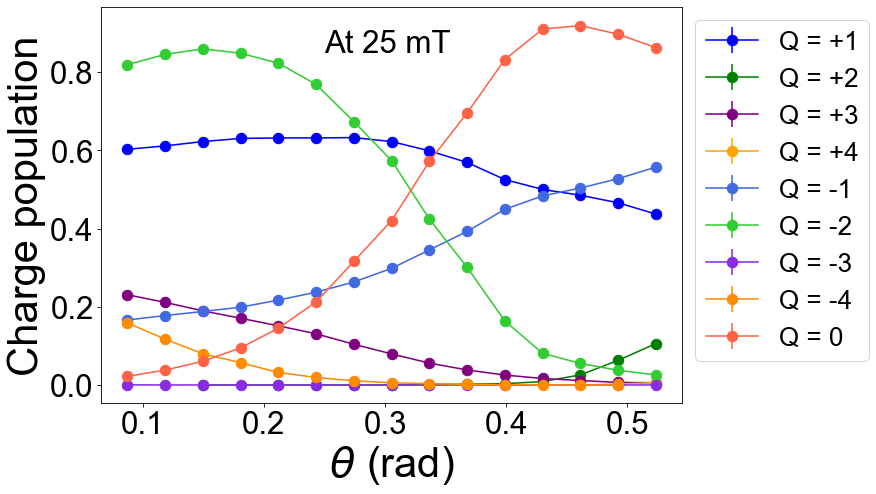

In [36]:
fig, ax1 = plt.subplots(figsize=(10,7))


for typ_m, mtype in LFrame.groupby('type'):
    
    ax1.errorbar(mtype.index.get_level_values('theta'), mtype["fraction"],yerr = mtype["err"], fmt ='-o', label = typ_m,markersize = 10)

    
ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)  

ax1.legend(fontsize = 25, bbox_to_anchor=(1, 1))
ax1.set_xlabel(r'$\theta$ (rad)', size = 40)
ax1.set_ylabel('Charge population', size = 40)
ax1.text(0.25, 0.85 ,'At 25 mT', size = 30)

In [27]:
LFrame3 = LFrame.query('coordination == 3')
LFrame4= LFrame.query('coordination == 4')

In [28]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "navy", "tomato", 
                                                    "red", "plum", "blue", 
                                                    "navy", "tomato",
                                                    "red"]) 

Q = +1
Q = +3
Q = -1
Q = -3
Q = +2
Q = +4
Q = -2
Q = -4
Q = 0


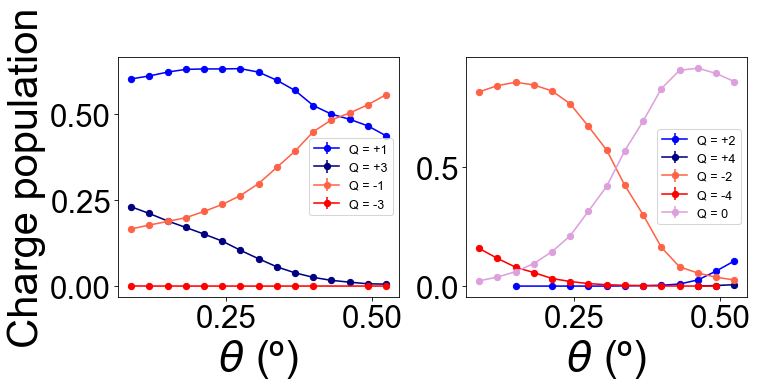

In [32]:
fig, ax = plt.subplots(1, 2,figsize=(10,5))

for typ_m, mtype in LFrame3.groupby('type'):
    print(typ_m)
    
    ax[0].errorbar(mtype.index.get_level_values('theta'), mtype["fraction"],yerr = mtype["err"],fmt = '-o', label = typ_m)

for typ_m, mtype in LFrame4.groupby('type'):
    print(typ_m)
    ax[1].errorbar(mtype.index.get_level_values('theta'), mtype["fraction"],yerr = mtype["err"], fmt ='-o',label = typ_m)

ax[0].tick_params(axis='y', labelsize=30)
ax[0].tick_params(axis='x', labelsize=30)  

ax[0].legend(fontsize = 12)
ax[0].set_xlabel(r'$\theta$ (º)', size = 40)
ax[0].set_ylabel('Charge population', size = 40)

ax[1].tick_params(axis='y', labelsize=30)
ax[1].tick_params(axis='x', labelsize=30)  

ax[1].legend(fontsize = 12)
ax[1].set_xlabel(r'$\theta$ (º)', size = 40)


plt.tight_layout()

In [11]:
LFrame['charge'] = LFrame.index.get_level_values('type')

In [12]:
def charge_value(row):
    
    value = int(row['charge'][-2:])
    return value

In [13]:
LFrame['charge'] = LFrame.apply (lambda row: charge_value(row) , axis=1)

In [14]:
LFrame

number  fraction       err  time  charge
theta    type   coordination                                              
0.523599 Q = +1 3             216.727273  0.436950  0.002167  2500       1
         Q = +2 4              25.363636  0.105682  0.002291  2500       2
         Q = +3 3               2.886364  0.005819  0.000557  2500       3
         Q = +4 4               1.454545  0.006061  0.000851  2500       4
         Q = -1 3             276.227273  0.556910  0.001993  2500      -1
...                                  ...       ...       ...   ...     ...
0.087266 Q = -1 3              82.465116  0.166260  0.001969  2500      -1
         Q = -2 4             196.511628  0.818798  0.004225  2500      -2
         Q = -3 3               0.279070  0.000563  0.000155  2500      -3
         Q = -4 4              38.139535  0.158915  0.003874  2500      -4
         Q = 0  4               5.348837  0.022287  0.001604  2500       0

[117 rows x 5 columns]

In [15]:
LFrame['fraction*charge'] = LFrame['fraction']*LFrame['charge']
LFrame

number  fraction       err  time  charge  \
theta    type   coordination                                                 
0.523599 Q = +1 3             216.727273  0.436950  0.002167  2500       1   
         Q = +2 4              25.363636  0.105682  0.002291  2500       2   
         Q = +3 3               2.886364  0.005819  0.000557  2500       3   
         Q = +4 4               1.454545  0.006061  0.000851  2500       4   
         Q = -1 3             276.227273  0.556910  0.001993  2500      -1   
...                                  ...       ...       ...   ...     ...   
0.087266 Q = -1 3              82.465116  0.166260  0.001969  2500      -1   
         Q = -2 4             196.511628  0.818798  0.004225  2500      -2   
         Q = -3 3               0.279070  0.000563  0.000155  2500      -3   
         Q = -4 4              38.139535  0.158915  0.003874  2500      -4   
         Q = 0  4               5.348837  0.022287  0.001604  2500       0   

                              fraction*charge  
theta    type   coordination                   
0.523599 Q = +1 3                    0.436950  
         Q = +2 4                    0.211364  
         Q = +3 3                    0.017458  
         Q = +4 4                    0.024242  
         Q = -1 3                   -0.556910  
...                                       ...  
0.087266 Q = -1 3                   -0.166260  
         Q = -2 4                   -1.637597  
         Q = -3 3                   -0.001688  
         Q = -4 4                   -0.635659  
         Q = 0  4                    0.000000  

[117 rows x 6 columns]

In [16]:
sum_df = LFrame.groupby(['theta','coordination']).sum()

In [38]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue","red"])

Text(0, 0.5, '$\\sum_{q} n_{z=3,4}q$')

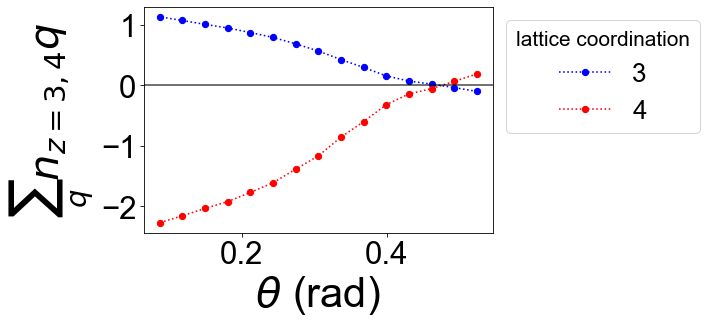

In [40]:
for typ_m, mtype in sum_df.groupby(['coordination']):
    
    plt.plot(mtype.index.get_level_values('theta'), mtype['fraction*charge'],':o', label = typ_m)

plt.yticks(fontsize=30, ticks=[-2,-1,0,1])
plt.tick_params(axis='x', labelsize=30)  
plt.legend(title = 'lattice coordination', fontsize = 25, bbox_to_anchor=(1, 1), title_fontsize = 20)
plt.axhline(y=0, color='black',alpha = 0.7, linestyle='-')
plt.xlabel(r'$\theta$ (rad)', size = 40)
plt.ylabel(r'$\sum_{q} n_{z=3,4}q$', size = 40)